# Week 7 - LSTM and GRU

# September 22, 2023.


Divide the data into train/validation data sets, build 2 models to perform movie review sentiment analysis


In [13]:
# Importing necessary files
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional

# Downloading NLTK data
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Parameters
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
vocab_size = 10000
embedding_dim = 100
max_length = 100

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
zip_path='/content/drive/MyDrive/Personal/archive.zip'

extract_folder = '/content/extracted_data'  # Path where zip will be extracted

# Ensure the folder exists, if not, create it
os.makedirs(extract_folder, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

In [15]:
# Paths to the CSV files
train_csv_path = '/content/extracted_data/Train.csv'
test_csv_path = '/content/extracted_data/Test.csv'
validation_csv_path = '/content/extracted_data/Valid.csv'

# Load the data
train_data = pd.read_csv(train_csv_path)
test_data = pd.read_csv(test_csv_path)
validation_data = pd.read_csv(validation_csv_path)

In [16]:
train_data

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
...,...,...
39995,"""Western Union"" is something of a forgotten cl...",1
39996,This movie is an incredible piece of work. It ...,1
39997,My wife and I watched this movie because we pl...,0
39998,"When I first watched Flatliners, I was amazed....",1


1. Perform required text pre-processing – lowering text, removing URLs, punctuation , stop words and
   correct spelling .
2. Perform tokenization and lemmatization on cleaned data .


In [30]:
tqdm.pandas()
def preprocess_text(text):
    """Preprocess a single text string."""
    text = text.lower()
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^\w\s]', '', text)
    return text

def tokenize_and_lemmatize(text):
    """Tokenize and lemmatize a single text string."""
    words = word_tokenize(text)
    # Adding 'br' to the set of words to remove
    words_to_remove = stop_words.union({'br'})
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words if word not in words_to_remove]
    return lemmatized_words

def preprocess_and_tokenize(text_series):
    """Apply preprocessing and tokenization to a Pandas Series of text."""
    # Wrapping text_series with tqdm to display progress bar
    return text_series.progress_apply(lambda x: tokenize_and_lemmatize(preprocess_text(x)))

# Assuming train_data, test_data, and validation_data are already defined
train_data['processed_text'] = preprocess_and_tokenize(train_data['text'])
test_data['processed_text'] = preprocess_and_tokenize(test_data['text'])
validation_data['processed_text'] = preprocess_and_tokenize(validation_data['text'])

100%|██████████| 5000/5000 [00:07<00:00, 710.13it/s]


In [31]:
all_words = [word for text in train_data['processed_text'] for word in text]
unique_words = set(all_words)
vocab_size = len(unique_words)
print(f"Total unique words: {vocab_size}")

max_length = max(train_data['processed_text'].apply(len))
print(f"Maximum length of a sequence: {max_length}")

Total unique words: 149146
Maximum length of a sequence: 1439


3. Visualize the most frequent words and bigrams.


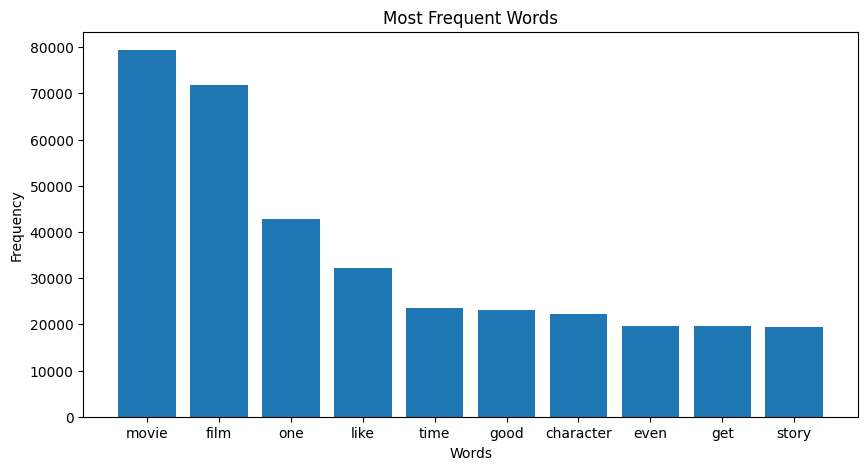

In [32]:
# Visualize most frequent words
all_words = [word for text in train_data['processed_text'] for word in text]
freq_words = Counter(all_words)
plt.figure(figsize=(10, 5))
plt.bar(*zip(*freq_words.most_common(10)))
plt.title('Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

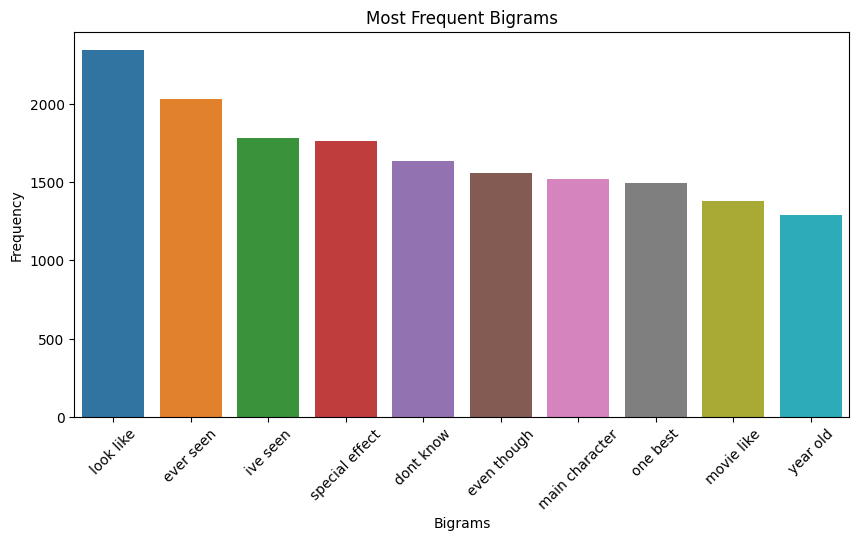

In [33]:
# Visualize most frequent bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2))
X = vectorizer.fit_transform(train_data['processed_text'].apply(' '.join))
bigrams = pd.DataFrame(X.sum(axis=0), columns=vectorizer.get_feature_names_out()).T
bigrams.columns = ['frequency']
bigrams = bigrams.sort_values(by='frequency', ascending=False)
plt.figure(figsize=(10, 5))
sns.barplot(x=bigrams.index[:10], y=bigrams['frequency'][:10])
plt.title('Most Frequent Bigrams')
plt.xlabel('Bigrams')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

4. Visualize the practical words that represent positive and negative sentiment in the dataset.


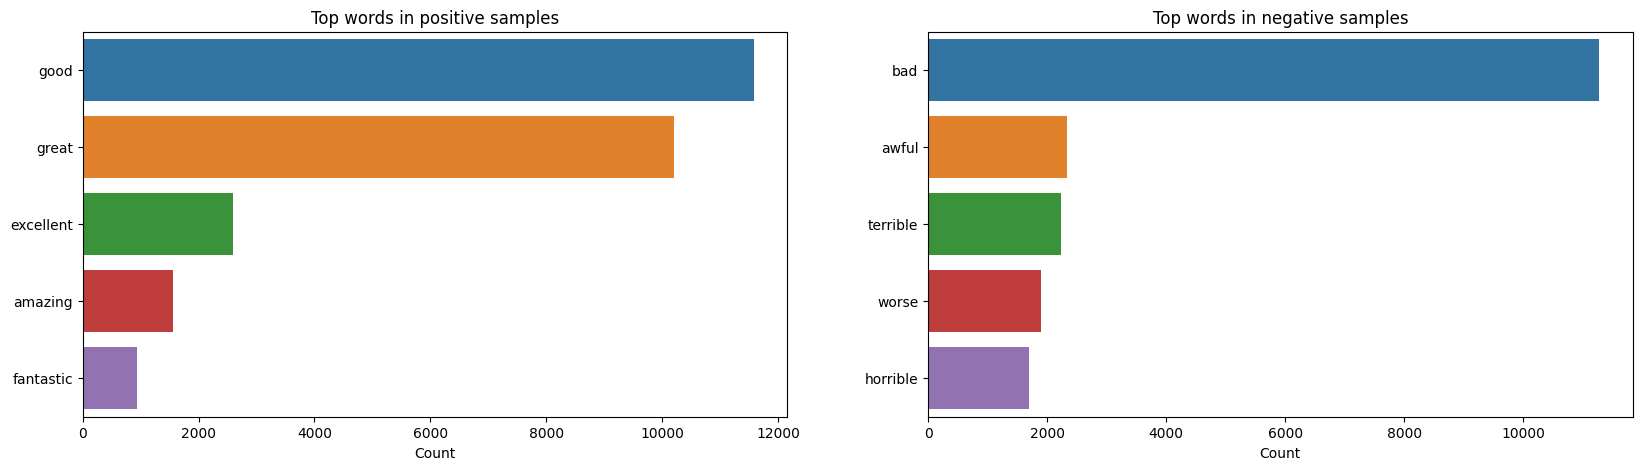

In [64]:
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

# List of words typically associated with positive or negative sentiments
positive_keywords = set(['good', 'great', 'amazing', 'fantastic', 'excellent'])
negative_keywords = set(['bad', 'worse', 'terrible', 'awful', 'horrible'])

# Separate and filter words in positive and negative samples
positive_words = [
    word
    for text, label in zip(train_data['processed_text'], train_data['label'])
    if label == 1
    for word in text
    if word.lower() in positive_keywords
]

negative_words = [
    word
    for text, label in zip(train_data['processed_text'], train_data['label'])
    if label == 0
    for word in text
    if word.lower() in negative_keywords
]

# Get the most common words in positive and negative samples
top_positive_words = Counter(positive_words).most_common(10)
top_negative_words = Counter(negative_words).most_common(10)

# Create subplots
fig, ax = plt.subplots(1, 2, figsize=(20, 5))

# Plot for positive words
sns.barplot(x=[count for word, count in top_positive_words], y=[word for word, count in top_positive_words], ax=ax[0])
ax[0].set_title('Top words in positive samples')
ax[0].set_xlabel('Count')

# Plot for negative words
sns.barplot(x=[count for word, count in top_negative_words], y=[word for word, count in top_negative_words], ax=ax[1])
ax[1].set_title('Top words in negative samples')
ax[1].set_xlabel('Count')

plt.show()

5. Create an embedding layer and build a 15 layer LSTM/GRU and a 20 layer BidRNN for predicting
   the sentiment.


In [36]:
from tensorflow.keras import layers, models
model_15_lstm = models.Sequential()
model_15_lstm.add(layers.Embedding(vocab_size, embedding_dim, input_length=max_length))

# Adding 15 LSTM layers
for _ in range(15):
    model_15_lstm.add(layers.LSTM(64, return_sequences=True))
model_15_lstm.add(layers.Dense(1, activation='sigmoid'))

model_15_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [38]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

# Tokenizing the text data
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_data['processed_text'])

# Converting text to sequences
train_sequences = tokenizer.texts_to_sequences(train_data['processed_text'])
validation_sequences = tokenizer.texts_to_sequences(validation_data['processed_text'])

# Padding sequences
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding='post', truncating='post')

In [43]:
history = model_15_lstm.fit(
    train_padded,  # Training data
    train_data['label'],  # Training labels
    epochs=5,  # Number of epochs
    batch_size=64,  # Batch size
    validation_data=(validation_padded, validation_data['label']),  # Validation data
    verbose=1  # To display training logs
)

Epoch 1/5
625/625 [==============================] - 501s 802ms/step - loss: 0.6932 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.4972
Epoch 2/5
625/625 [==============================] - 430s 689ms/step - loss: 0.6932 - accuracy: 0.4985 - val_loss: 0.6932 - val_accuracy: 0.4972
Epoch 3/5
625/625 [==============================] - 411s 658ms/step - loss: 0.6932 - accuracy: 0.4956 - val_loss: 0.6932 - val_accuracy: 0.4972
Epoch 4/5
625/625 [==============================] - 400s 641ms/step - loss: 0.6932 - accuracy: 0.4977 - val_loss: 0.6931 - val_accuracy: 0.5028
Epoch 5/5
625/625 [==============================] - 393s 629ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.4972


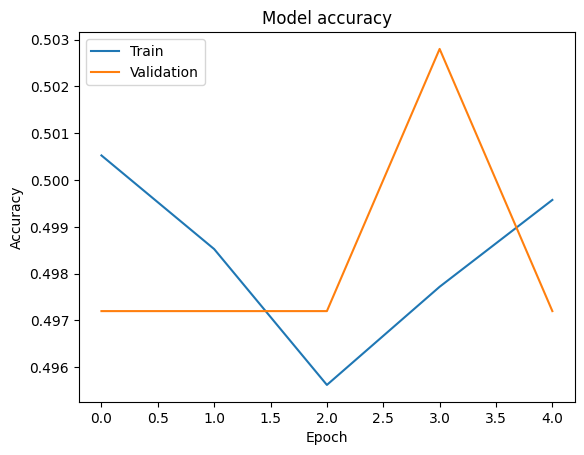

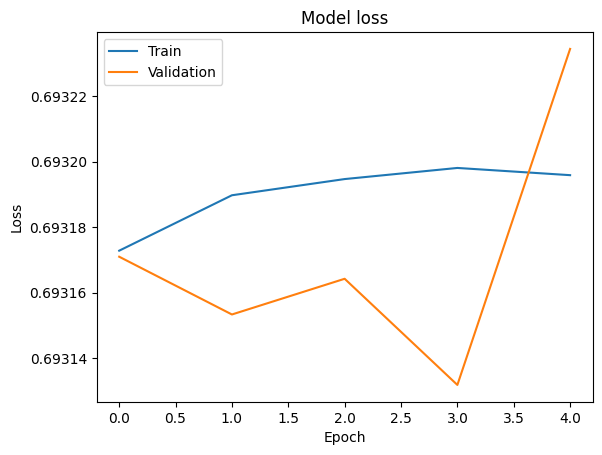

In [44]:
import matplotlib.pyplot as plt

# Plotting training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [47]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length))
for _ in range(20):  # Adding 20 BidRNN layers
    model.add(Bidirectional(LSTM(units=16, return_sequences=True)))
    model.add(Dropout(0.5))  # Adding dropout for regularization
model.add(Dense(units=1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1439, 100)         14914600  
                                                                 
 bidirectional_20 (Bidirect  (None, 1439, 32)          14976     
 ional)                                                          
                                                                 
 dropout_20 (Dropout)        (None, 1439, 32)          0         
                                                                 
 bidirectional_21 (Bidirect  (None, 1439, 32)          6272      
 ional)                                                          
                                                                 
 dropout_21 (Dropout)        (None, 1439, 32)          0         
                                                                 
 bidirectional_22 (Bidirect  (None, 1439, 32)         

In [48]:
history = model.fit(
    train_padded,  # Training data
    train_data['label'],  # Training labels
    epochs=5,  # Number of epochs
    batch_size=64,  # Batch size
    validation_data=(validation_padded, validation_data['label']),  # Validation data
    verbose=1  # To display training logs
)

Epoch 1/5
625/625 [==============================] - 978s 1s/step - loss: 0.6933 - accuracy: 0.5008 - val_loss: 0.6933 - val_accuracy: 0.4972
Epoch 2/5
625/625 [==============================] - 869s 1s/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6932 - val_accuracy: 0.4972
Epoch 3/5
625/625 [==============================] - 861s 1s/step - loss: 0.6932 - accuracy: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.4972
Epoch 4/5
625/625 [==============================] - 796s 1s/step - loss: 0.6932 - accuracy: 0.5029 - val_loss: 0.6933 - val_accuracy: 0.4972
Epoch 5/5
625/625 [==============================] - 832s 1s/step - loss: 0.6932 - accuracy: 0.5008 - val_loss: 0.6932 - val_accuracy: 0.4972


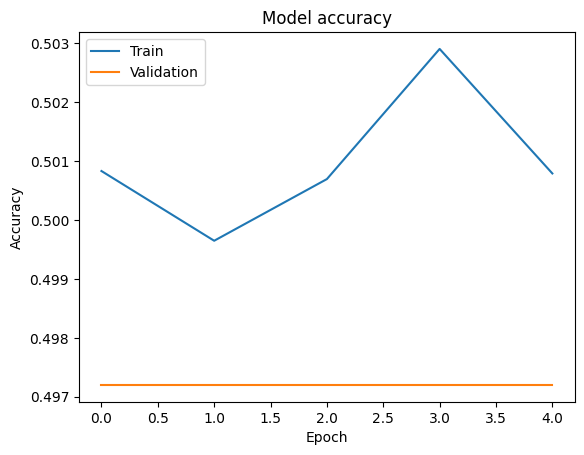

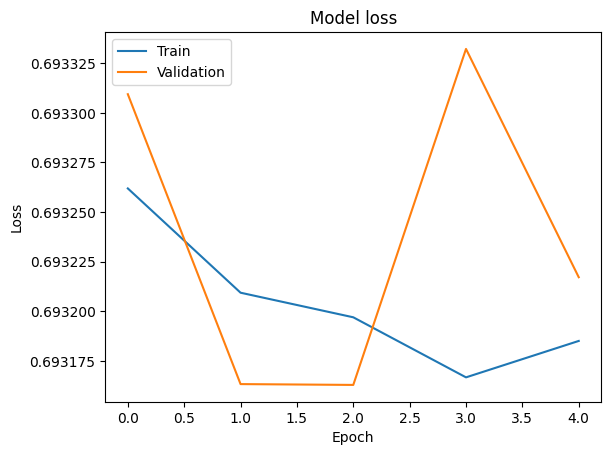

In [49]:
# Plotting training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plotting training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

6. Build your own test dataset with 10 movie reviews and tabulate accuracy


In [58]:
# Example Test Data
test_reviews = [
    "The movie was fantastic!",
    "Absolutely loved it, a masterpiece!",
    "What a waste of time.",
    "The plot was dull and characters were not developed.",
    "Incredible! Best movie of the year!",
    "Not worth the hype.",
    "Simply beautiful.",
    "Impressive visuals but lacking in story.",
    "I was moved to tears.",
    "Unimpressive and forgettable."
]
test_labels =[1, 1, 0, 0, 1, 0, 1, 1, 1, 0]
# Assuming a tokenizer was previously defined and fitted on the training data
test_sequences = tokenizer.texts_to_sequences(test_reviews)
padded_test_sequences = pad_sequences(test_sequences, maxlen=max_length)  # Use the same maxlen as during training

In [59]:
predictions = model_15_lstm.predict(padded_test_sequences)
predicted_labels_1 = (predictions > 0.5).astype(int).flatten()
print(predicted_labels_1)

1/1 [==============================] - 0s 321ms/step
[0 0 0 ... 0 0 0]


In [60]:
predictions = model.predict(padded_test_sequences)
predicted_labels_2 = (predictions > 0.5).astype(int).flatten()
print(predicted_labels_2)

1/1 [==============================] - 1s 596ms/step
[0 0 0 ... 0 0 0]


In [62]:
# Compute Metrics
import numpy as np
accuracy_1 = np.mean(predicted_labels_1 == test_labels)
accuracy_2 = np.mean(predicted_labels_2 == test_labels)

# Display Metrics
print(f"Predicted labels by Model 1: {predicted_labels_1}")
print(f"Predicted labels by Model 2: {predicted_labels_2}")
print(f"Model 1 Accuracy: {accuracy_1 * 100:.2f}%")
print(f"Model 2 Accuracy: {accuracy_2 * 100:.2f}%")

Predicted labels by Model 1: [0 0 0 ... 0 0 0]
Predicted labels by Model 2: [0 0 0 ... 0 0 0]
Model 1 Accuracy: 0.00%
Model 2 Accuracy: 0.00%


<ipython-input-62-86950f28298f>:3: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy_1 = np.mean(predicted_labels_1 == test_labels)
<ipython-input-62-86950f28298f>:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  accuracy_2 = np.mean(predicted_labels_2 == test_labels)
